In [1]:
# Install Tesseract OCR
!apt-get install -y tesseract-ocr tesseract-ocr-ukr
!pip install pytesseract opencv-python easyocr stanza pdf2image transformers pandas
!pip install -r requirements.txt
!pip install deskew
!pip install language_tool_python


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd tesseract-ocr-ukr
0 upgraded, 4 newly installed, 0 to remove and 30 not upgraded.
Need to get 6,119 kB of archives.
After this operation, 19.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-ukr all 1:4.00~git30-7274cfa-1.1 [1,303 kB]
Fetched 6,119 kB in 2s (3,787 kB/s)
Selecting previously unselected pa

In [204]:
import cv2
import numpy as np
import pandas as pd
import os
import pytesseract
from PIL import Image, ImageEnhance
import matplotlib.pyplot as plt
from deskew import determine_skew
from typing import Tuple, Union, List

In [220]:
class ImagePreprocessor:
    """
    Class for preprocessing images before OCR to improve recognition quality.
    Handles issues with image quality, skew/angle, lighting, and noise.
    """

    def __init__(self, debug_mode: bool = False):
        """
        Initialize the ImagePreprocessor.

        Args:
            debug_mode: If True, displays intermediate processing steps
        """
        self.debug_mode = debug_mode

    def load_image(self, image_path: str) -> np.ndarray:
        """
        Load an image from a file path.

        Args:
            image_path: Path to the image file

        Returns:
            Loaded image as numpy array
        """
        if not os.path.exists(image_path):
            raise FileNotFoundError(f"Image file not found: {image_path}")

        image = cv2.imread(image_path)
        if image is None:
            raise ValueError(f"Could not load image: {image_path}")

        return image

    def _show_debug_image(self, image: np.ndarray, title: str):
        """Display image if debug mode is enabled."""
        if self.debug_mode:
            plt.figure(figsize=(10, 10))
            if len(image.shape) == 3:
                plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            else:
                plt.imshow(image, cmap='gray')
            plt.title(title)
            plt.axis('off')
            plt.show()

    def resize_image(self, image: np.ndarray, scale_percent: int = 100) -> np.ndarray:
        """
        Resize image by given percentage.

        Args:
            image: Input image
            scale_percent: Percentage to scale the image

        Returns:
            Resized image
        """
        width = int(image.shape[1] * scale_percent / 100)
        height = int(image.shape[0] * scale_percent / 100)
        dim = (width, height)

        resized = cv2.resize(image, dim, interpolation=cv2.INTER_AREA)
        self._show_debug_image(resized, "Resized Image")

        return resized

    def correct_skew(self, image: np.ndarray) -> np.ndarray:
        """
        Detect and correct skew in an image.

        Args:
            image: Input image

        Returns:
            Deskewed image
        """
        # Convert to grayscale if needed
        gray = image.copy()
        if len(image.shape) == 3:
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Determine the skew angle
        angle = determine_skew(gray)

        # If skew is minimal, return original image
        if abs(angle) < 0.5:
            return image

        # Rotate the image to correct the skew
        (h, w) = image.shape[:2]
        center = (w // 2, h // 2)
        M = cv2.getRotationMatrix2D(center, angle, 1.0)
        rotated = cv2.warpAffine(
            image,
            M,
            (w, h),
            flags=cv2.INTER_CUBIC,
            borderMode=cv2.BORDER_REPLICATE
        )

        self._show_debug_image(rotated, f"Deskewed Image (angle: {angle:.2f}°)")
        return rotated

    def enhance_contrast(self, image: np.ndarray) -> np.ndarray:
        """
        Enhance contrast using CLAHE (Contrast Limited Adaptive Histogram Equalization).

        Args:
            image: Input image

        Returns:
            Contrast-enhanced image
        """
        # Convert to LAB color space
        if len(image.shape) == 3:
            lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
            l, a, b = cv2.split(lab)

            # Apply CLAHE to L channel
            clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
            cl = clahe.apply(l)

            # Merge channels and convert back to BGR
            enhanced_lab = cv2.merge((cl, a, b))
            enhanced = cv2.cvtColor(enhanced_lab, cv2.COLOR_LAB2BGR)
        else:
            # Apply CLAHE directly to grayscale image
            clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
            enhanced = clahe.apply(image)

        self._show_debug_image(enhanced, "Contrast Enhanced")
        return enhanced

    def advanced_denoise(self, image: np.ndarray) -> np.ndarray:
        """
        Apply multiple denoising techniques for better noise reduction.

        Args:
            image: Input image

        Returns:
            Advanced denoised image
        """
        # Convert to grayscale if needed
        if len(image.shape) == 3:
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        else:
            gray = image.copy()

        # Step 3: Apply non-local means denoising for remaining noise
        final = cv2.fastNlMeansDenoising(gray, None, 10, 7, 21)
        self._show_debug_image(final, "Advanced Denoised")

        return final

    def morphological_operations(self, image: np.ndarray) -> np.ndarray:
        """
        Apply morphological operations to clean up the image.

        Args:
            image: Input image (should be binary/grayscale)

        Returns:
            Cleaned image
        """
        # Ensure image is grayscale
        if len(image.shape) == 3:
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        else:
            gray = image.copy()

        # Create kernels for morphological operations
        kernel = np.ones((2, 2), np.uint8)

        # Apply opening to remove small noise
        opening = cv2.morphologyEx(gray, cv2.MORPH_OPEN, kernel)
        self._show_debug_image(opening, "Opening")

        # Apply closing to fill small holes in text
        closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)
        self._show_debug_image(closing, "Closing")

        return closing

    def adaptive_binarization(self, image: np.ndarray) -> np.ndarray:
        """
        Improved binarization with noise consideration.

        Args:
            image: Input image

        Returns:
            Better binarized image with less noise
        """
        # Convert to grayscale if needed
        if len(image.shape) == 3:
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        else:
            gray = image.copy()

        # Try Otsu's thresholding first (works well for bimodal images)
        _, otsu = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        self._show_debug_image(otsu, "Otsu Thresholding")

        # Also try adaptive thresholding
        adaptive = cv2.adaptiveThreshold(
            gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
            cv2.THRESH_BINARY, 19, 11  # Increased block size and constant
        )
        self._show_debug_image(adaptive, "Adaptive Thresholding")

        # Combine both methods (this often preserves text better)
        combined = cv2.bitwise_and(otsu, adaptive)
        self._show_debug_image(combined, "Combined Binarization")

        return combined

    def process_image(self, image_path: str) -> np.ndarray:
        """
        Improved processing pipeline with better noise handling.

        Args:
            image_path: Path to the input image

        Returns:
            Fully preprocessed image ready for OCR
        """
        # Load image
        image = self.load_image(image_path)
        self._show_debug_image(image, "Original Image")

        # Step 1: Resize for better resolution
        image = self.resize_image(image, scale_percent=200)

        # Step 2: Advanced denoising
        denoised = self.advanced_denoise(image)

        # Step 4: Enhance contrast
        contrast = self.enhance_contrast(denoised)

        # Step 5: Correct skew
        deskewed = self.correct_skew(contrast)

        # Step 6: Improved binarization
        binary = self.adaptive_binarization(deskewed)

        # Step 7: Apply morphological operations to clean up
        cleaned = self.morphological_operations(binary)

        return cleaned

In [225]:
import language_tool_python

class PostProcessor:
    def __init__(self):
        # Initialize the LanguageTool client for Ukrainian
        self.tool = language_tool_python.LanguageTool('uk-UA')

    def clean_formatting(self, text):
        # Basic formatting fixes, like extra spaces
        text = text.replace(" ,", ",").replace(" .", ".")
        text = text.replace("  ", " ").strip()
        return text


    def correct_spelling_and_grammar(self, text):
        # Find mistakes using LanguageTool
        matches = self.tool.check(text)
        # Apply corrections to the text
        corrected_text = language_tool_python.utils.correct(text, matches)
        return corrected_text

    def process(self, text):
        text = self.clean_formatting(text)
        text = self.correct_spelling_and_grammar(text)
        return text


In [235]:
class UkrainianOCR:
    """
    Class for performing OCR on Ukrainian documents using Tesseract.
    """

    def __init__(self,
                tesseract_path: str = None,
                lang: str = "ukr+eng",  # Adding English as fallback
                preprocessor: ImagePreprocessor = None,
                postprocessor: PostProcessor = None):
        """
        Initialize the OCR engine.

        Args:
            tesseract_path: Path to Tesseract executable
            lang: Language code for Tesseract (ukr for Ukrainian)
            preprocessor: Image preprocessor instance
        """
        if tesseract_path:
            pytesseract.pytesseract.tesseract_cmd = tesseract_path

        self.lang = lang

        # Check if Ukrainian language data is available
        try:
            langs = pytesseract.get_languages()
            if "ukr" not in langs:
                print(f"Warning: Ukrainian language pack not found in Tesseract. "
                      f"Available languages: {langs}")
                print("Please install the Ukrainian language pack for Tesseract.")

                # Fall back to English if Ukrainian is not available
                if "eng" in langs:
                    self.lang = "eng"
                    print("Falling back to English OCR.")
        except:
            print("Could not verify language availability. Make sure Tesseract is properly installed.")

        # Create a default preprocessor if none provided
        self.preprocessor = preprocessor if preprocessor else ImagePreprocessor()
        self.postprocessor = postprocessor if postprocessor else PostProcessor()

        # Custom configuration
        self.custom_config = None

    def set_custom_config(self, config: str):
        """
        Set custom configuration for Tesseract.

        Args:
            config: Tesseract configuration string
        """
        self.custom_config = config

    def _get_tesseract_config(self) -> str:
        """
        Get the Tesseract configuration.

        Returns:
            Tesseract configuration string
        """
        if self.custom_config:
            return self.custom_config

        # Default configuration optimized for Ukrainian/Cyrillic text
        config = f'--psm 3 --oem 3 -l {self.lang}'

        # Page segmentation modes (PSM):
        # 1 = Auto page segmentation with OSD
        # 3 = Fully automatic page segmentation, but no OSD (default)
        # 4 = Assume a single column of text of variable sizes
        # 6 = Assume a single uniform block of text

        # OCR Engine modes (OEM):
        # 1 = Neural nets LSTM engine only - better for complex scripts like Cyrillic
        # 3 = Default, based on what is available (LSTM + Legacy)

        return config

    def recognize_text(self, image: Union[str, np.ndarray]) -> str:
        """
        Perform OCR on an image to extract Ukrainian text.

        Args:
            image: Image path or numpy array

        Returns:
            Extracted text as string
        """
        # Process the image if it's a path
        if isinstance(image, str):
            processed_image = self.preprocessor.process_image(image)
        else:
            # Assume it's already a processed numpy array
            processed_image = image

        # Get Tesseract configuration
        config = self._get_tesseract_config()

        # Convert to PIL Image for better compatibility
        pil_image = Image.fromarray(processed_image)

        # Perform OCR
        text = pytesseract.image_to_string(pil_image, config=config)

        return self.postprocessor.process(text)

    def recognize_to_data(self, image: Union[str, np.ndarray]) -> pd.DataFrame:
        """
        Extract text with position and confidence information.

        Args:
            image: Image path or numpy array

        Returns:
            DataFrame with text, positions, and confidence scores
        """
        # Process the image if it's a path
        if isinstance(image, str):
            processed_image = self.preprocessor.process_image(image)
        else:
            # Assume it's already a processed numpy array
            processed_image = image

        # Get Tesseract configuration
        config = self._get_tesseract_config()

        # Use a PIL image for better compatibility
        pil_image = Image.fromarray(processed_image)

        # Extract detailed OCR data
        data = pytesseract.image_to_data(
            pil_image,
            config=config,
            output_type=pytesseract.Output.DATAFRAME
        )

        # Convert text column to string to handle float values
        data['text'] = data['text'].astype(str)

        # Filter out empty text and non-text entries
        data = data[data['text'].str.strip().astype(bool)]

        return data

    def recognize_file(self, file_path: str) -> str:
        """
        Process a file and perform OCR.

        Args:
            file_path: Path to the image file

        Returns:
            Extracted text
        """
        return self.recognize_text(file_path)


In [238]:
# Create preprocessor with debug mode enabled
tesseract_path = r"/usr/bin/tesseract"
preprocessor = ImagePreprocessor(debug_mode=False)

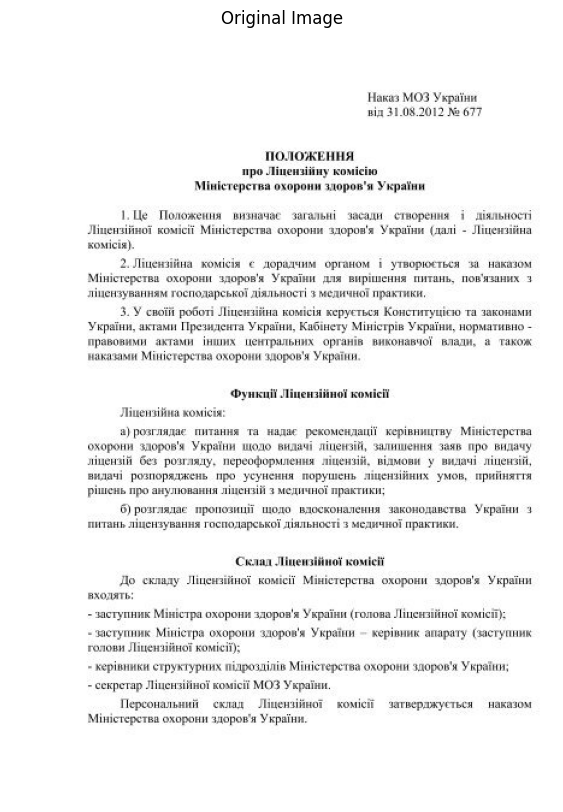

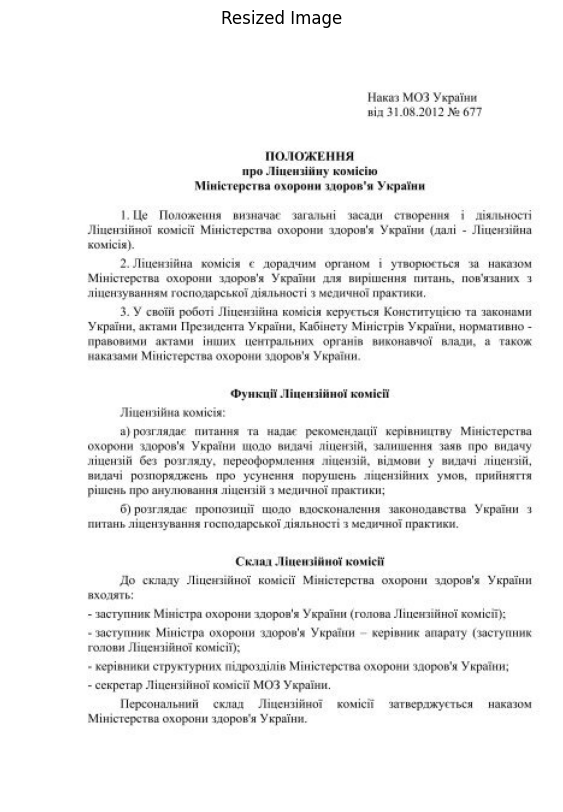

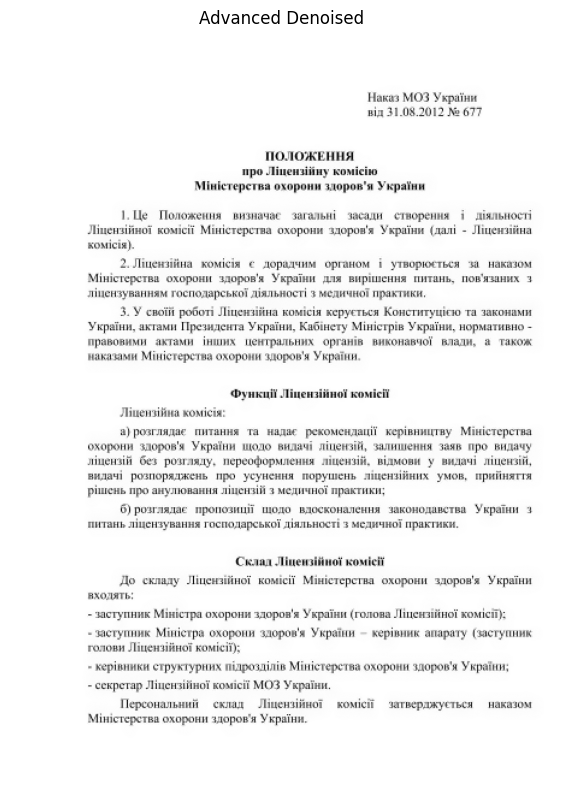

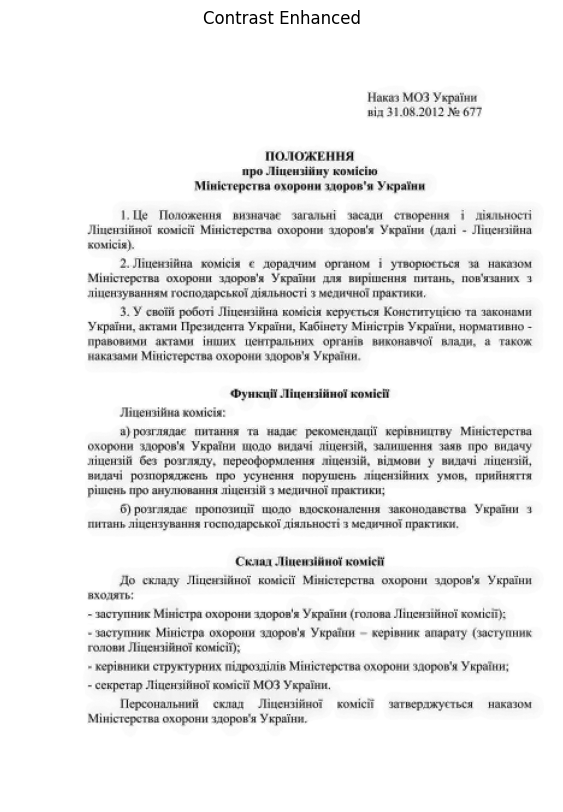

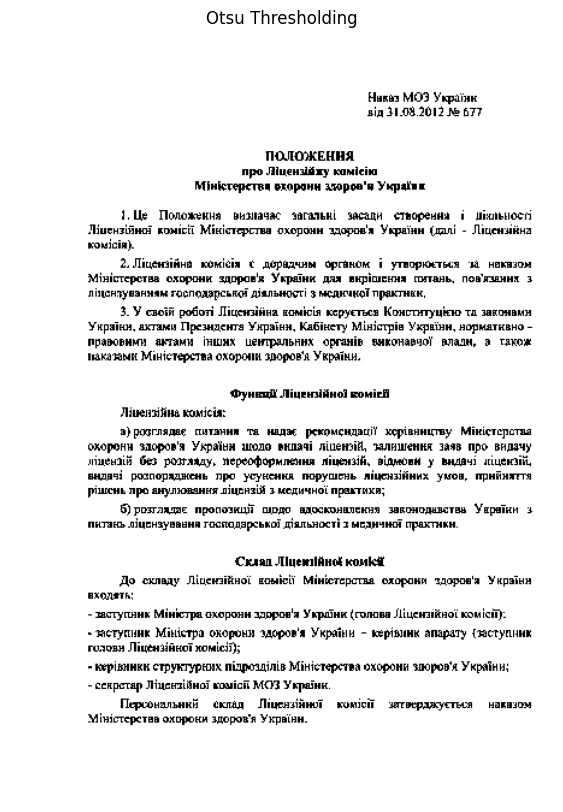

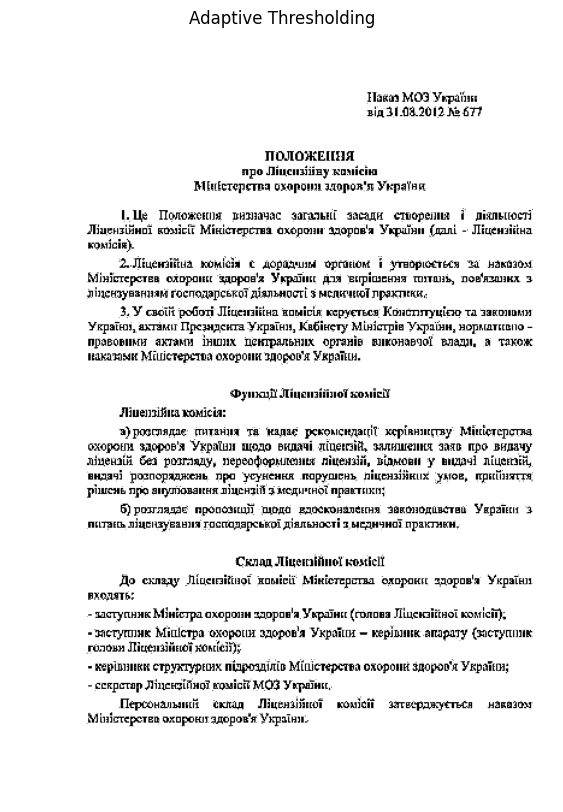

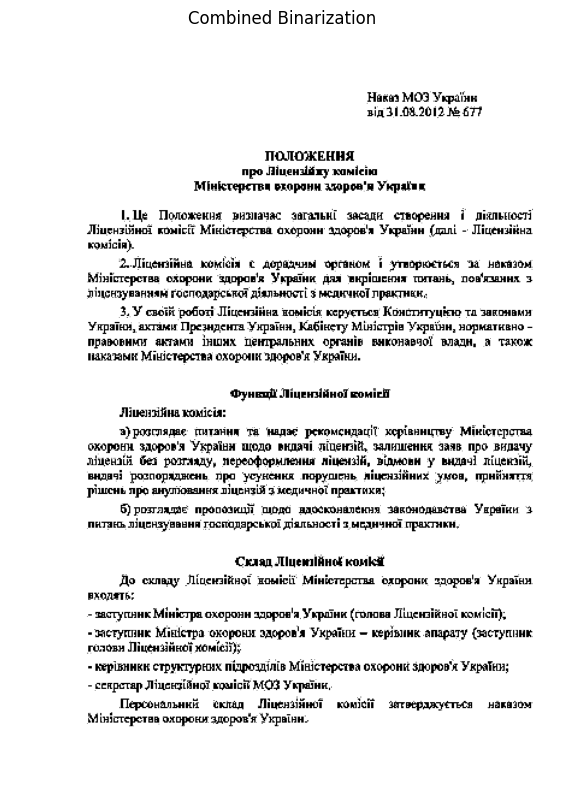

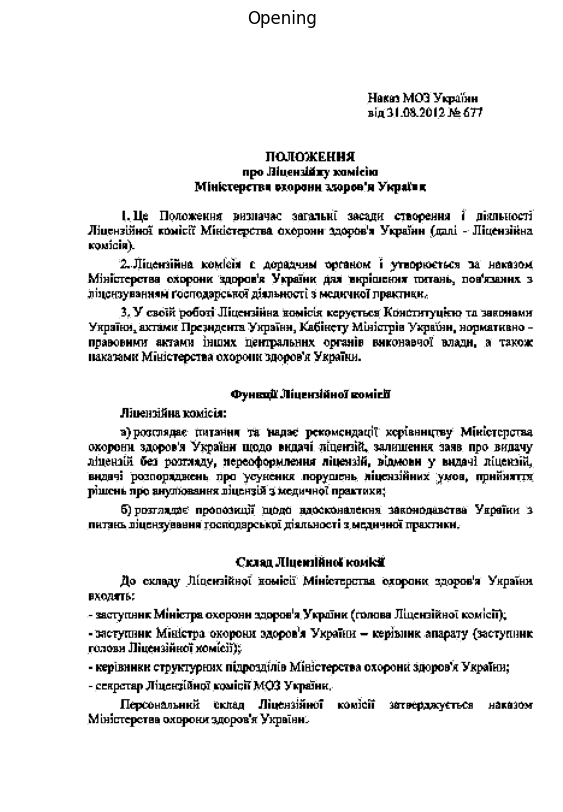

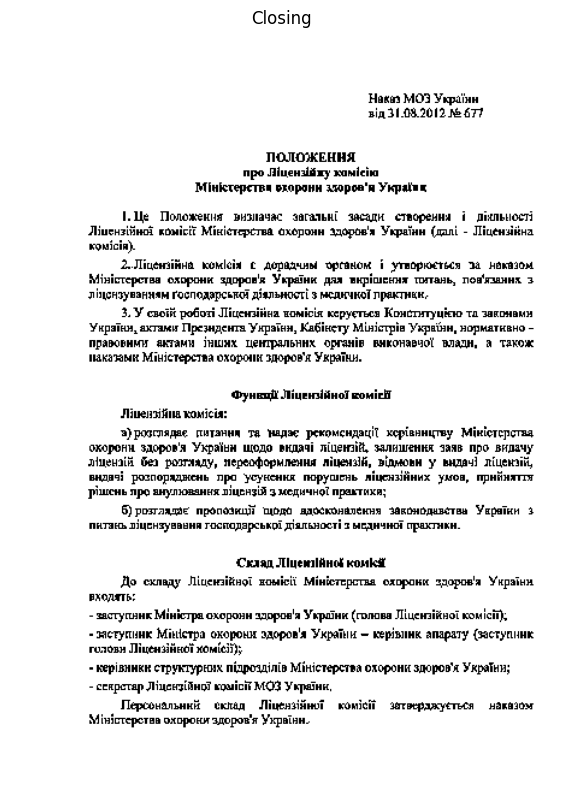

Наказ МОЗ України
звід 34.03.2012 ме БУ

ПОЛОЖЕННЯ
про Ліцензійну комісію
Міністерства Романн здоров'я України

І. Це Положення визначає загальні засади створення і діяльності
Ліцензійної комісії Міністерства охорони Зарів'я України (далі - Ліцензійна
комісія).

2.Ліцензійна комісія с дорадчим органом і утворюється За наказом
Міністерства охорони здоров'я України для рішення питань, пов'язаних з
ліцензуванням господарської діяльності з медичної практик.

3. У своїй роботі Ліцензійна нон місія керується Конституцією та законами
України, актами Президент України, Кабінету Міністрів України, нормативно -
правовим актами інших центральних органів виконавчої влади, а також
плакатами Міністерства охорони здоров'я України.

Функції Ліцензійної комісії
Ліцензійна комісія:
зуродглядяє питання та надає рекомендації керівництву Міністерства
вкорени здоров'я України щодо видачі ліцензій, залишення заяв про видачу
ліцензій фен реотану, переоформлення ліцензій, відмови у видачі ліцензій,
видачі розп

In [237]:
image_path = "/content/test-data/7.jpg"

ocr = UkrainianOCR(tesseract_path=tesseract_path, preprocessor=preprocessor)

# Recognize text
extracted_text = ocr.recognize_file(image_path)
# Print extracted text
print(extracted_text)
print("-" * 80)

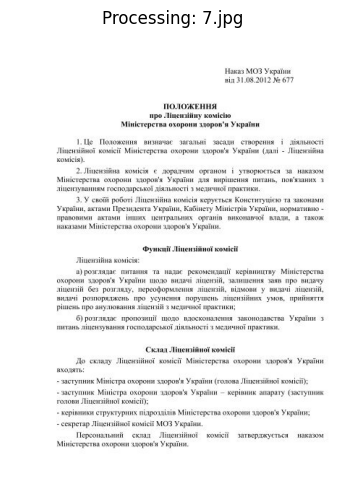

Extracted Text from 7.jpg:
Наказ МОЗ України
звід 34.03.2012 ме БУ

ПОЛОЖЕННЯ
про Ліцензійну комісію
Міністерства Романн здоров'я України

І. Це Положення визначає загальні засади створення і діяльності
Ліцензійної комісії Міністерства охорони Зарів'я України (далі - Ліцензійна
комісія).

2.Ліцензійна комісія с дорадчим органом і утворюється За наказом
Міністерства охорони здоров'я України для рішення питань, пов'язаних з
ліцензуванням господарської діяльності з медичної практик.

3. У своїй роботі Ліцензійна нон місія керується Конституцією та законами
України, актами Президент України, Кабінету Міністрів України, нормативно -
правовим актами інших центральних органів виконавчої влади, а також
плакатами Міністерства охорони здоров'я України.

Функції Ліцензійної комісії
Ліцензійна комісія:
зуродглядяє питання та надає рекомендації керівництву Міністерства
вкорени здоров'я України щодо видачі ліцензій, залишення заяв про видачу
ліцензій фен реотану, переоформлення ліцензій, відмови у в

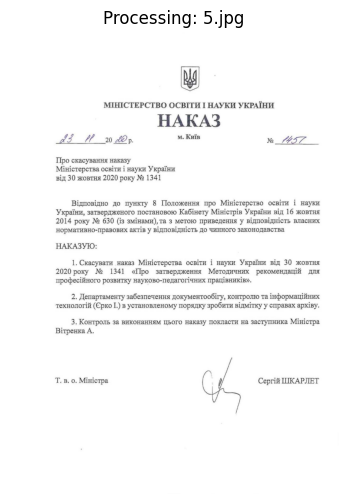

Extracted Text from 5.jpg:
МІНІСТЕРСТВО ОСВІТИ І НАУКИ УКРАЇНИ

НАКАЗ

a5 4 2» £0». м. Київ nn “ST

Про скасування наказу
Міністерства освіти й науки України
від 30 жовтня 2020 року Ме 1341

Відповідно до пункту 8 Положення про Міністерство освіти й науки
України, затвердженого постановою Кабінету Міністрів України від 16 жовтня
2014 року Хо 630 (зі змінами), та з метою приведення у відповідність власних
нормативно-правових актів у відповідність до чинного законодавства

НАКАЗУЮ:
1. Скасувати наказ Міністерства освіти й науки України від 30 жовтня
2020 року Ne 1341 «Про затвердження Методичних рекомендацій для

професійного розвитку науково-педагогічних працівників»,

2. Департаменту забезпечення документообігу, контролю та інформаційних
технологій (Єрко І.) в установленому порядку зробити відмітку у справах архіву.

3. Контроль за виконанням цього наказу покласти на заступника Міністра
Вітренка А.

Т. в. о, Міністра Сергій ШКАРЛЕТ
------------------------------------------------------

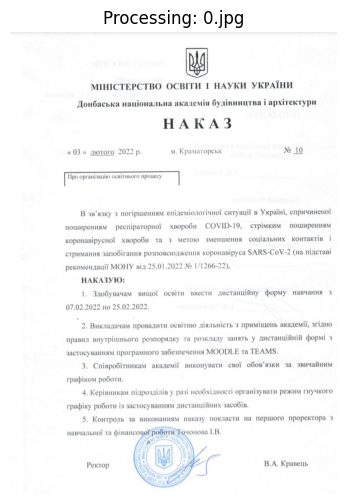

Extracted Text from 0.jpg:
МІНІСТЕРСТВО ОСВІТИ І НАУКИ УКРАЇНИ

Донбаська національна академія будівництва й архітектури

НАКАЗ

«03» лютого 2022 р. м, Краматорськ No 10
| Tipo організацію освітнього процесу

У зв'язку, а погіршенням епідеміологічної ситуації в Україні, спричиненої
поширенням 0 респіраторної хвороби COVID-19, стрімким поширенням
коронавірусної хвороби та з метою зменшення соціальних контактів і
стримання запобігання розповсюдження коронавірус 5АВЯ-СоМ"2 (на підставі
рекомендації МОНУ від 25.01.2022 Хе 10126622

НАКАЗУЮ:

1. Здобувачам вищої освіти вести дистанційну форму навчання з
07.02.2022 по 25.02.2022.

, 2. Викладачам провадити освітню діяльність з приміщень академії, згідно
з правним внутрішнього розпорядку та розкладу занять у дистанційній формі з
застосуванням програмного забезпечення МОЛОДІ.Е та ТЕАМ8.

3, Співробітникам академії виконувати свої обов'язки за звичайним
графіком роботи.

4. Керівникам підрозділів у разі необхідності організувати режим гнучкого 

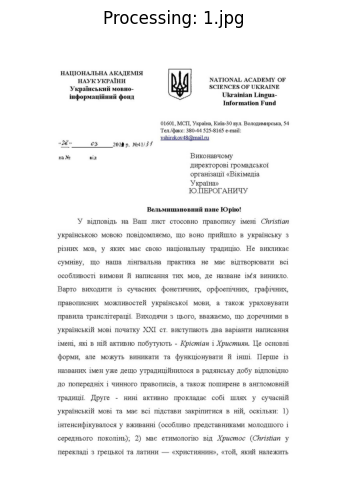

Extracted Text from 1.jpg:
НАЦІОНАЛЬНА АКАДЕМІЯ

НАУК УКРАЇНИ NATIONAL ACADEMY OF
Український мовної SCIENCES OF UKRAINE
інформаційний фонд Ukrainian Lingua-

Information Fund

01601, MCIT, Yxpaitia, Knis-30 кул. Володимирська, 34
Тел./факс: 380-44 525-8165 e-mail:

, vshirokov48@mail.m
«Аве 93 | 201 йр. наш Ft
на М: від виконавчого

директорові громадської
організації «Вікімедіа
Україна»
ЮЛЕРОГАНИЧУ

Вельмишановний пане Юрію!

У відповідь на Ваш лист стосовно правопису імені Дивізійна
українською мовою повідомляємо, що воно прийшло в українську з
різних мов, у яких має свою національну традицію. Не викликає
сумніву, що наша лінгвальна практика не має відтворювати всі
особливості вимови й написання тих мов, де назване ім'я виникло.
Варто виходити із сучасних фонетичних, орфоепічних, графічних,
правописних можливостей української мови, а також ураховувати
правила транслітерації. Виходячи з цього, вважаємо, що доречними в
українській мові початку XXI ст. виступають два варіанти написання

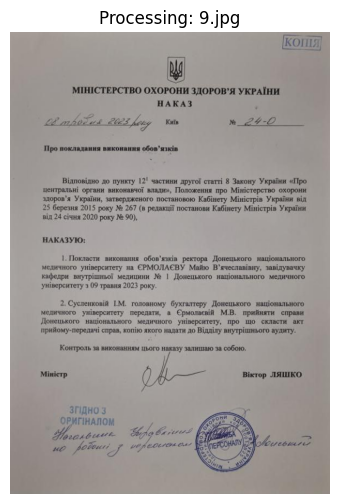

Extracted Text from 9.jpg:
КОПІЯ!

МІНІСТЕРСТВО ОХОРОНИ ЗДОРОВ'Я УКРАЇНИ
НАКАЗ,

"Дибання «БОЇ у Veatn n_ 29-0

Шар викладання виконаних обов'язків

Відповідно до пункту 12! частини другої статті 8 Закону України «Про
центральні органи виконавчої влади», Положення про Міністерство охорони
здоров'я України, затвердженого постановою Кабінету Міністрів України під
25 березня 2015 рожу Ме 267 (в редакції постанови Кабінету Міністрів України
від 24 січня 2020 року Ме 96),

НАКАЗУЮ

1. Покласти виконання обов'язків ректора Донецького національного
медичного університету на ЄРМОЛАЄВУ Мая В'ячеславівну, завідувачку
кафедри внутрішньої медицини Ке 1 Донецького національного медичного
університету з 09 травня 2023 року.

2. Сусленкові ЇМ. головному бухгалтеру Донецького національного
медичного університету передати, а Єрмолаєвій МВ. прийняти справи
Донецького національного медичного університету, про що скласти акт
прийняття-передання справ, копію якого надати до Відділу внутрішнього аудиту.

Ко

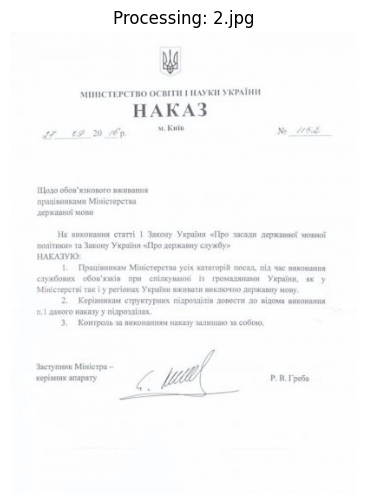

Extracted Text from 2.jpg:
МАЙСТЕРСТВО ОСВІТИ ГА» КІ У КРАХ

НАКАЗ

т 7 ся 10 б м. ким же тал

Важка обом нотаток нажинанню
працівниками Міністерства
деруни за

На кишіння статті | Зикову України «Про млини держаних кованої
політками» Fa Закону України «Про державну службу»
НАКАЗУЮ:

І Працівникам Міністерств унія категорій помад, до часу виконаних
службою обов'язків гри спілиунаммі Мо громадженими Урни, яко у
Міністерстві як | у регіолект, У країни акценти практично дистиляту шоку -

1 Крижинам струп курних нідробдінію доїсти так підйом виховання
п 1 дикого намоклу у нідреадіажх.

3. Контроль ЧА вимоканню Bey залишимо за собою.

корінних апаратів Й Р.Греба
--------------------------------------------------------------------------------


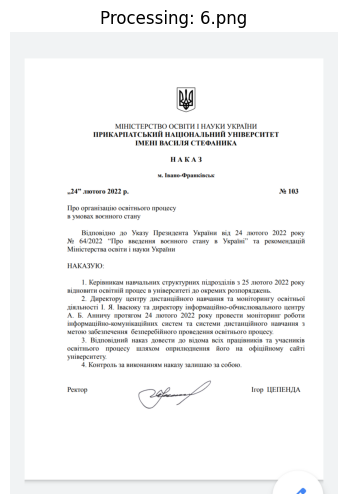

Extracted Text from 6.png:
МІНІСТЕРСТВО ОСВІТИ І НАУКИ УКРАЇНИ
ПРИКАРПАТСЬКИЙ НАЦІОНАЛЬНИЙ УНІВЕРСИТЕТ
ІМЕНІ ВАСИЛЯ СТЕФАНИКА

НАКАЗ
м. Івано-Франківськ
324" лютого 2022 р. Ne 103

Про організацію освітнього процесу
в умовах воєнного стану

Відповідно до Указу Президента України від 24 лютого 2022 року
Хе 64/2022 "Про введення воєнного стану в Україні" та рекомендацій
Міністерства освіти й науки України

НАКАЗУЮ:

1. Керівникам навчальних структурних підрозділів з 25 лютого 2022 року
відновити освітній процес в університеті до окремих розпоряджень.

2. Директору центру дистанційного навчання та моніторингу освітньої
діяльності І. Я. Івасюку та директору інформаційно-обчислювального центру
А. Б. Аннину протягом 24 лютого 2022 року провести моніторинг роботи
інформаційно-комунікаційних систем та системи дистанційного навчання з
метою забезпечення безперебійного проведення освітнього процесу.

3. Відповідний наказ довести до відома всіх працівників та учасників
освітнього процесу шляхом о

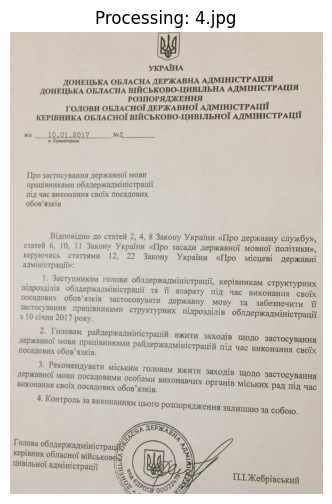

Extracted Text from 4.jpg:
УКРАЇНА

СТРАТІЯ
ДОНЕЦЬКА ОБЛАСНА державному АДМІНІ
ДОНЕЦЬКА ОБЛАСНА ВІЙСЬКОВО-ЦИВІЛЬНА АДМІНІСТРАЦІЯ
РОЗПОРЯДЖУ
ІЛЮСТРАЦІЇ

ГОЛОВИ ОБЛАСНОЇ ДЕРЖАВНОЇ АДАМ.
КЕРІВНИКА ОБЛАСНОЇ ВІЙСЬКОВО-ЦИВІЛЬНОЇ АДМІНІСТРАЦІЇ

З | 10.01.2019 oa
м Краматорськ

Про застосування державної мови.
працівниками облдержадміністрації
під час виконання своїх посадових
обов'язків

Відповідно до статей 2, 4, 8 Закону України «Про державну службу»,
статей би, 10, 1! Закону України «Про засади державної мовної політики»,
керуючись статтями 12, 22 Закону України «Про місцеві державні
адміністрації»:

_ 1, Заступникам голови облдержадміністрації, керівникам структурних
підрозділів облдержадміністрації та Її апарату під час виконання своїх
посадових обов'язків застосовувати державну мову та забезпечити if
застосування працівниками структурних підрозділів облуде адміністрації
з ІД січня 2017 року. P

2, Головам райдержадміністрацій вжити заходів щодо застосування
державної мови працівниками р

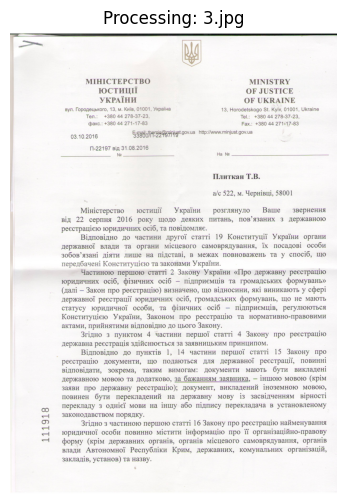

Extracted Text from 3.jpg:
111918

МІНІСТЕРСТВО | МІМІ5ТВУ

Юстиції OF JUSTICE
УКРАЇНИ OF UKRAINE
вул. Городецького, 13, м. Київ, 01001, Україна 13, Horodetskogo St. Kyiv, 01001, Ukraine
Ten.: +380 44 278-37-23, Tel.: +380 44 278-37-23,
факс.: -380 44 271-17-83 Бах. 1380 44 271-17-83
03.10.2016 І опері ві прав дома http://www. minjust.gov.ua
П1-22197 від 31.08.2016

Мо На Мо

Плитка Т.В.
а/с 522, м. Чернівці, 58001

Міністерство | юстиції України розглянуло Ваше звернення

звід 22 серпня 2016 року щодо деяких питань, пов'язаних з державною

Реєстрацією юридичних осіб, та повідомляє.

Відповідно до частини другої статті 19 Конституції України органи
державної влади та органи місцевого самоврядування, їх посадові особи
зобов'язані діяти лише на підставі, в межах повноважень та у спосіб, що
передбачені Конституцією та законами України.

«Феліцатиною першою статті 2 Закону України «Про державну реєстрацію
юридичних осіб, фізичних осіб - підприємців та громадських формувань»
(далі - Закон п

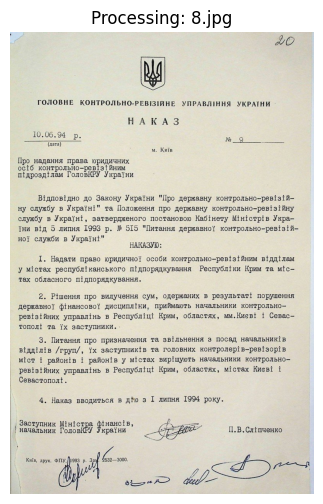

Extracted Text from 8.jpg:
Й LO

\.
+ Kitts, zyx. ФА-ДІЄЗ р. Заступник. Lo sen

ГОЛОВНЕ КОНТРОЛЬНО-РЕВІЗІЙНЕ УПРАВЛІННЯ УКРАЇНИ -

НАКАЗ
10.06.94 р.

fo
(дата) м 9

м. Київ

Про надання права юридичних
осіб контрольно-ревізійні ним
підрозділам ГоловКРУ України

Відповідна до Закону України "Про державну контрольно-ревізійне
ну службу в Україні" та Положення про державну контрольно-ревізійну
службу в Україні, затвердженого постановою Кабінету Міністрів Украй
їй від би липня 1993 р. М 515 "Питання державної контрольно-ревізійне
Ної служби в Україні"

й Р НАКАЗУЮ:

1. Надати право юридичної особи контрольно-ревізійним відділам
у містах республіканського підпорядкування Республіки Крим та міст
та обласного підпорядкування.

8. Рішення про вилучення сум, одержаних в результаті порушення
державної фінансової дисципліни, приймають начальники контрольної
ревізійних управлінь в Республіці Крим, областях, мм.Києві й Свасі
тополі та їх заступники, -

3. Питання про призначення та звільнення з пос

In [240]:
dir_path = "test-data"


# Process each image in the folder
for filename in os.listdir(dir_path):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp', '.gif')):
        image_path = os.path.join(dir_path, filename)

        # Load and display the image
        image = cv2.imread(image_path)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(10, 6))
        plt.imshow(image_rgb)
        plt.axis('off')
        plt.title(f"Processing: {filename}")
        plt.show()

        ## Create OCR engine
        ocr = UkrainianOCR(tesseract_path=tesseract_path, preprocessor=preprocessor)

        # Recognize text
        extracted_text = ocr.recognize_file(image_path)
        # Print extracted text
        print(f"Extracted Text from {filename}:")
        print(extracted_text)
        print("-" * 80)
